# BNL Development Notebook

This notebook is for developing and testing the BNL package.


In [1]:
%load_ext autoreload
%autoreload 2

import bnl

# R2_BUCKET_PUBLIC_URL = "https://pub-05e404c031184ec4bbf69b0c2321b98e.r2.dev"
slm_ds_local = bnl.data.Dataset(manifest_path="~/data/salami/metadata.csv")
# slm_ds_cloud = bnl.data.Dataset(manifest_path=f"{R2_BUCKET_PUBLIC_URL}/manifest_cloud_boolean.csv")
track = next(iter(slm_ds_local))

In [2]:
## let's get an estimate hierarchy for a track:
# WIP this API should be better.
slm_ds = bnl.data.Dataset(manifest_path="~/data/salami/metadata.csv")
track = slm_ds[3]
# Let's check what annotations are available for this track
print("Available annotations:", list(track.annotations.keys()))

# Try loading an Adobe annotation that exists
est = track.load_annotation("adobe-mu1gamma1")
est

Available annotations: ['adobe-mu1gamma1', 'adobe-mu1gamma9', 'adobe-mu5gamma5', 'reference']


TS(B(0.0)-B(276.63673), adobe-mu1gamma1)

<Axes: title={'center': 'L03'}, xlabel='Time (s)'>

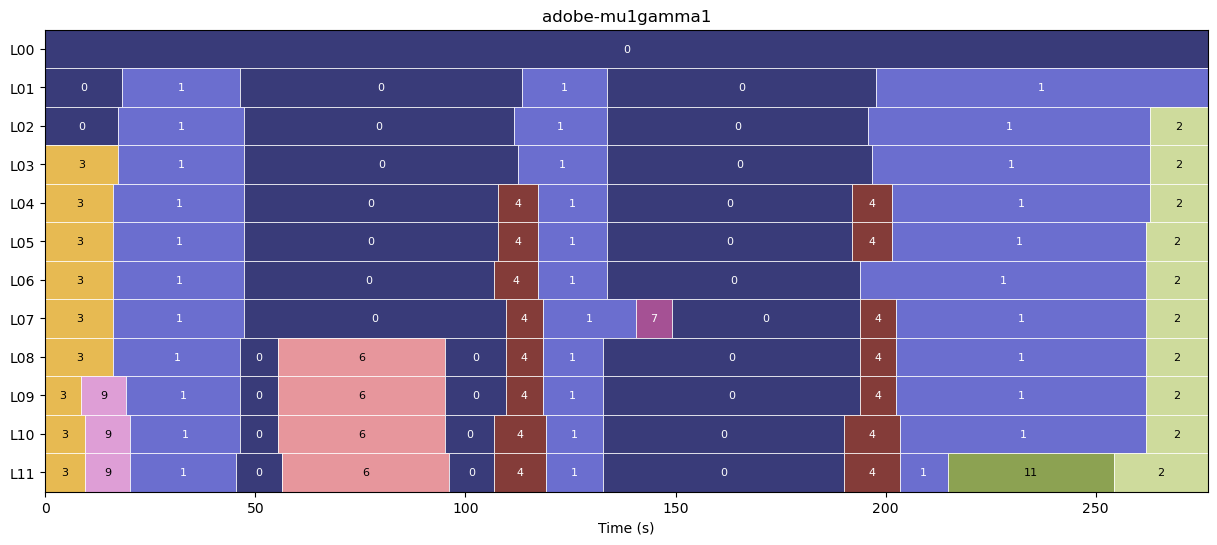

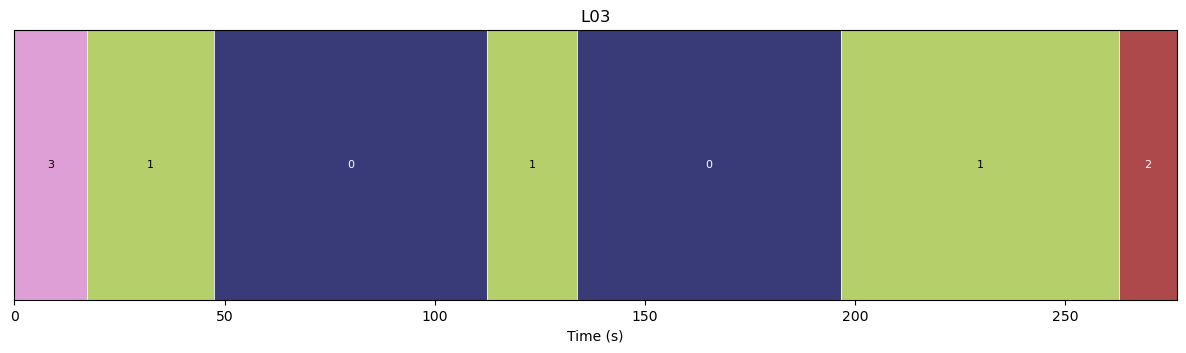

In [3]:
est.plot()
est[3].plot()

<Axes: title={'center': 'ref-5'}, xlabel='Time (s)'>

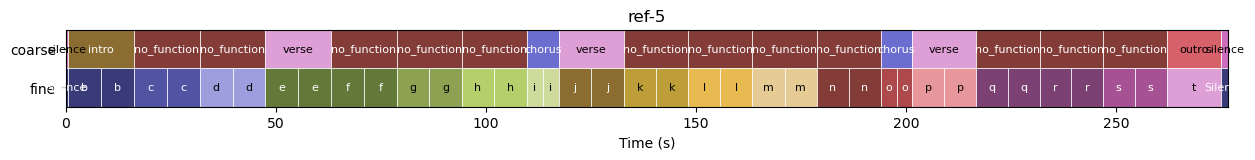

In [6]:
ref = track.load_annotation("reference")
ref.plot()

In [58]:
bnl.ops.naive_salience(est).label_context

AttributeError: 'Boundary' object has no attribute 'label'

In [ ]:
# up next to write to_hierarchy

In [31]:
rated_b = bnl.strategies.CoarsestNonzeroStrategy().calculate(est)
proper_h = bnl.strategies.DirectSynthesisStrategy().quantize(rated_b)

AttributeError: module 'bnl' has no attribute 'strategies'

In [32]:
proper_h.plot()

NameError: name 'proper_h' is not defined

<Axes: title={'center': 'adobe-mu1gamma9'}, xlabel='Time (s)'>

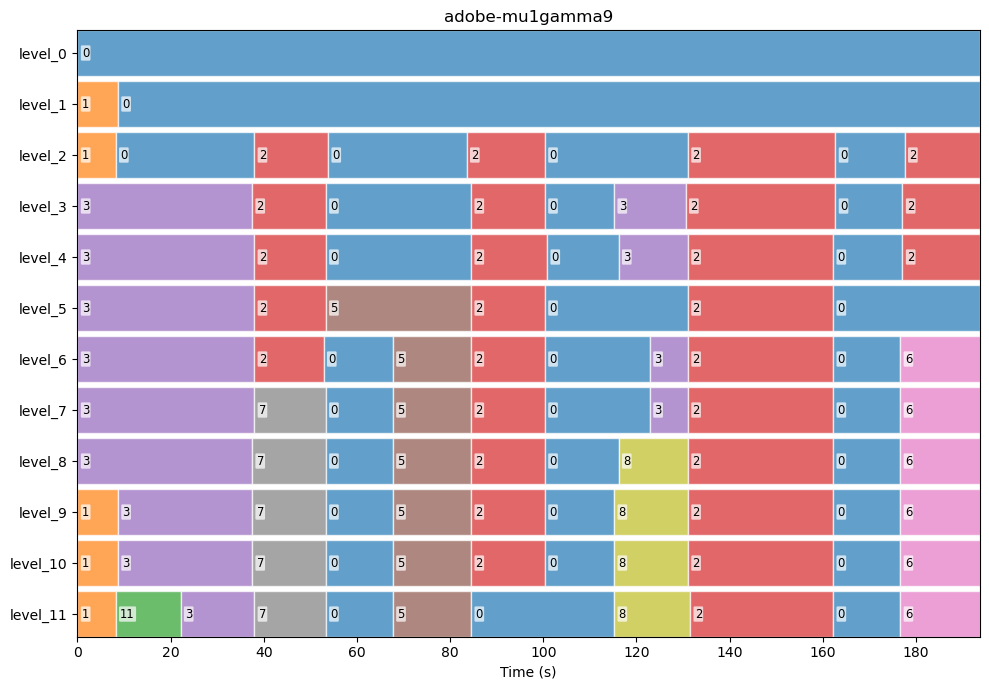

In [20]:
est.plot()

Text(0.5, 1.0, 'TimeSpan([1.0-3.0s])')

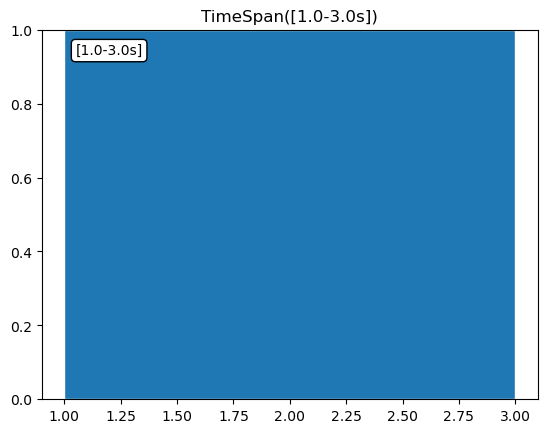

In [ ]:
span = bnl.TimeSpan(1, 3)

fig, ax = span.plot()
ax.set_title(repr(span))

<string>:15: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


(<Figure size 1000x450 with 1 Axes>,
 <Axes: title={'center': 'direct_synthesis'}, xlabel='Time (s)'>)

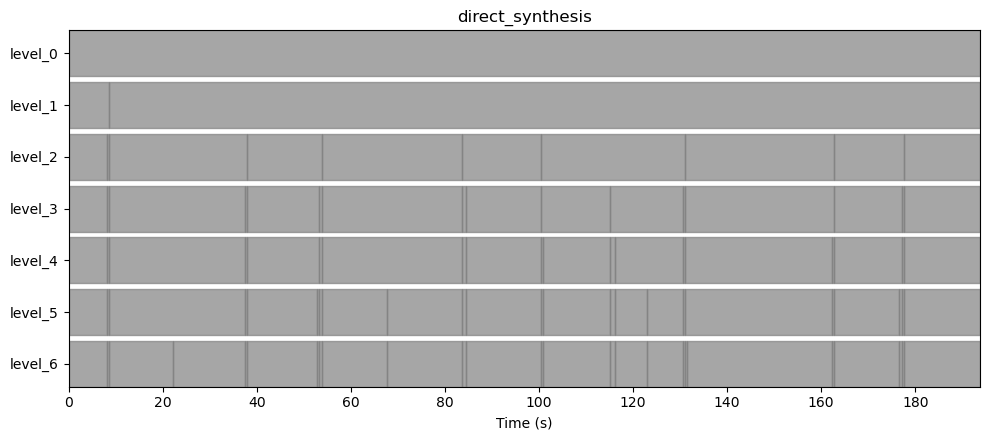

In [16]:
proper_h.plot()

In [9]:
est[2].boundaries

(Boundary(time=0.0, label='1'),
 Boundary(time=8.2, label='0'),
 Boundary(time=37.95, label='2'),
 Boundary(time=53.79, label='0'),
 Boundary(time=83.54, label='2'),
 Boundary(time=100.33, label='0'),
 Boundary(time=131.04, label='2'),
 Boundary(time=162.7, label='0'),
 Boundary(time=177.58, label='2'),
 Boundary(time=193.75, label=None))

In [10]:
proper_h[2].boundaries

(Boundary(time=0.0, label=None),
 Boundary(time=8.2, label=None),
 Boundary(time=8.68, label=None),
 Boundary(time=37.95, label=None),
 Boundary(time=53.79, label=None),
 Boundary(time=83.54, label=None),
 Boundary(time=100.33, label=None),
 Boundary(time=131.04, label=None),
 Boundary(time=162.7, label=None),
 Boundary(time=177.58, label=None),
 Boundary(time=193.75, label=None))

(0.0, 2.0)

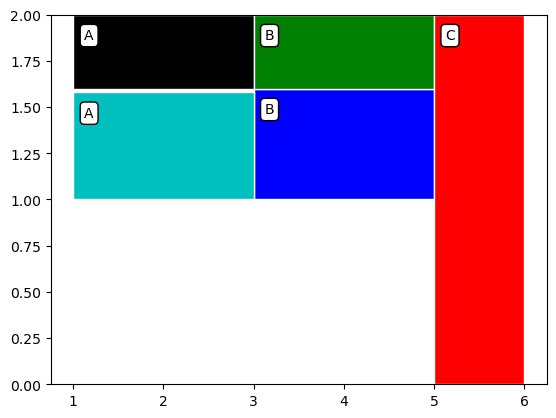

In [ ]:
seg = bnl.Segmentation.from_boundaries([1, 3, 5, 6], labels=["A", "B", "C", "D"])

fig, ax = seg[0].plot(ymin=0.8, ymax=1.0, color="k")

seg[1].plot(ax=ax, ymin=0.5, ymax=0.8, color="b")
seg[1].plot(ax=ax, ymin=0.8, ymax=1.0, color="g")
seg[2].plot(ax=ax, color="r")
seg[0].plot(ax=ax, ymin=0.5, ymax=0.79, color="c")

ax.set_ylim(0, 2)